In [77]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import KFold
from explainable import LM
from ensemble import LGB, RF
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimSun']
import warnings
warnings.filterwarnings('ignore')

In [78]:
df = pd.read_csv('data/widetable_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25466 entries, 0 to 25465
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   NATURAL_CUST_ID                        25466 non-null  int64  
 1   target_M2plus                          25466 non-null  int64  
 2   target_owe_fee_rate                    25466 non-null  float64
 3   FLAG_M2_HISTORY                        25466 non-null  int64  
 4   OWETAG_OWE_FEE_N_RATIO_VL_OLD          25466 non-null  float64
 5   OWETAG_OWE_FEE_L12M_RATIO_VL_OLD       25466 non-null  float64
 6   OWETAG_OWE_TIME_L12M_MX_OLD            25466 non-null  int64  
 7   OWETAG_OWE_PERIOD_L12M_MX              25466 non-null  int64  
 8   COSHQW_ACCT_FEE_N_D3MR                 25466 non-null  float64
 9   COSHQW_CUST_N_D3M                      25466 non-null  int64  
 10  FLAG_M1_HISTORY                        25466 non-null  int64  
 11  CO

In [119]:
print(df['target_M2plus'].value_counts(normalize=True))
print('='*20)
print(df['target_oweRate_binary'].value_counts(normalize=True))

0    0.887811
1    0.112189
Name: target_M2plus, dtype: float64
0    0.837862
1    0.162138
Name: target_oweRate_binary, dtype: float64


In [102]:
# K-fold CV to control randomness
K = 10
CV = KFold(n_splits=K, shuffle=True, random_state=667)
KF_DATASETS = enumerate(CV.split(df))

### M2+: LGB v.s. LR v.s. RF

In [80]:
# Data Parameters
PK = 'NATURAL_CUST_ID'
TARGET_1 = 'target_M2plus'
DROP_1 = [PK] + ['target_owe_fee_rate', 'target_oweRate_binary','INDUSTRYCONAME', 'INDUSTRYCONAME_oweRateProb']
FEATURES_1 = df.drop(columns=DROP_1).columns.tolist()

# WOE Feature Screening and Transformation
EMP = 0.9; IV = 0.02; COR = 0.7
X2DROP = True
BIN_METHOD = 'chi'; BIN_MIN = 0.05
WOE_METHOD = 'aic'; WOE_REG = 'ridge'

# Model Selections
MODELS = ['LR', 'LightGBDT','RF','LR_WOE', 'LightGBDT_WOE','RF_WOE']

#### Training

In [81]:
def woe_transform(train, test, target,
                  empty, iv, corr,
                  return_drop, exclude,
                  bin_method, bin_min_samples,
                  woe_method, estimator):
    import toad
    train_selected, dropped = toad.selection.select(frame=train, target=target, 
                                                    empty=empty, iv=iv, corr=corr, 
                                                    return_drop=return_drop, 
                                                    exclude=exclude)
        # 只对训练数据做WOE特征筛选，然后再泛化到测试数据上
        # empyt=0.9: 缺失值大于0.9的变量被删除
        # iv=0.02: iv值小于0.02的变量被删除
        # corr=0.7: 两个变量相关性高于0.7时，iv值低的变量被删除
        # return_drop=False: 若为True，function将返回被删去的变量列
        # exclude=None: 明确不被删去的列名，输入为list格式
    # print('>>> Dropped Features in EDA: ',dropped, f'(with criterion where empty = {EMP}, IV = {IV}, corr = {COR})')

    COMBINER = toad.transform.Combiner()
    COMBINER.fit(train_selected.drop(exclude, axis=1), y=target, method=bin_method, min_samples=bin_min_samples) 
        # empty_separate = False
        # 使用特征筛选后的数据进行训练：使用稳定的卡方分箱，规定每箱至少有5%数据, 空值将自动被归到最佳箱。
        # 支持chi(卡方分箱), dt(决策树分箱), kmean, quantile, step(等步长分箱)
        # min_samples: 每箱至少包含样本量，可以是数字或者占比
        # n_bins: 箱数，若无法分出这么多箱数，则会分出最多的箱数
    
    TRANSFORMER = toad.transform.WOETransformer() # 初始化
    train_woe = TRANSFORMER.fit_transform(COMBINER.transform(train_selected), train_selected[target], exclude=exclude)
    test_woe = TRANSFORMER.transform(COMBINER.transform(test)) 
        # 根据训练好的transer，转化test/OOT数据
        # 本质上也是把特征筛选逻辑进行泛化

    transformed_train, woe_dropped = toad.selection.stepwise(train_woe, target=target, estimator=estimator,
                                                             direction='both', criterion=woe_method, 
                                                             exclude=exclude, return_drop=return_drop) 
        # 将WOE转化后的数据做逐步回归,本质上也是特征筛选
        # estimator: 用于拟合的模型，支持'ols', 'lr', 'lasso', 'ridge'
        # direction: 逐步回归的方向，支持'forward', 'backward', 'both' （推荐）
        # criterion: 评判标准，支持'aic', 'bic', 'ks', 'auc'
        # max_iter: 最大迭代次数
        # return_drop: 是否返回被剔除的列名
    transformed_train[target] = train[target] # 确保目标没有被WOE
    transformed_test = test_woe[transformed_train.columns.tolist()] # 将选出的变量应用于test/OOT数据
    transformed_test[target] = test[target] # 确保目标没有被WOE
    features_in = transformed_train.columns.tolist()
    # print('>>> Dropped Features in WOE-fitting: ',woe_dropped,f'(with criterion = {WOE_METHOD} and estimator = {WOE_REG})')
    return transformed_train, transformed_test, features_in

def model_selection(task, KF_DATASETS, TARGET, DROP, FEATURES, 
                    EMP, IV, COR, X2DROP, BIN_METHOD, BIN_MIN, WOE_METHOD, WOE_REG,
                    MODELS,
                    COMPARE_PARAM = False, n_estimators_uplimit = 500, K = 3):
        MODEL_LIS = {}
        TEST_INDICATORS = []; TRAIN_INDICATORS = []
        for i, (train_index, test_index) in KF_DATASETS:
                TRAIN = df[df.index.isin(train_index)]
                TEST = df[df.index.isin(test_index)]
                transformed_train, transformed_test, features_in = woe_transform(TRAIN, TEST, TARGET,
                                                                                EMP, IV, COR,
                                                                                X2DROP, DROP,
                                                                                BIN_METHOD, BIN_MIN,
                                                                                WOE_METHOD, WOE_REG)
                MODEL_UNIT = {}
                for MODEL in tqdm(MODELS,colour='green',desc=f'>> Dataset {i}, Model Processing'):
                        if 'WOE' in MODEL:
                                ACTUAL_TRAIN_X = transformed_train.drop(DROP+[TARGET], axis=1)
                                ACTUAL_TRAIN_Y = transformed_train[TARGET]
                                ACTUAL_TEST_X = transformed_test.drop(DROP+[TARGET], axis=1)
                                ACTUAL_TEST_Y = transformed_test[TARGET]
                        else:
                                ACTUAL_TRAIN_X = TRAIN.drop(DROP+[TARGET], axis=1)
                                ACTUAL_TRAIN_Y = TRAIN[TARGET]
                                ACTUAL_TEST_X = TEST.drop(DROP+[TARGET], axis=1)
                                ACTUAL_TEST_Y = TEST[TARGET]
                        if 'LR' in MODEL:
                                model = LM(ACTUAL_TRAIN_X, ACTUAL_TRAIN_Y, ACTUAL_TEST_X, ACTUAL_TEST_Y)
                                model.GLM(mark = MODEL,task = task,
                                          compare_param = COMPARE_PARAM, K=K, class_weight=None, quiet=True)
                        elif 'RF' in MODEL:
                                model = RF(MODEL, task, ACTUAL_TRAIN_X, ACTUAL_TRAIN_Y, ACTUAL_TEST_X, ACTUAL_TEST_Y,
                                        feature_names = FEATURES, target_name = TARGET, 
                                        compare_param = COMPARE_PARAM, n_estimators_uplimit=n_estimators_uplimit, K=K)
                                model.training(quiet=True)
                                model.evaluation(quiet=True)
                        # elif 'GBDT' in MODEL:
                        #         model = GBDT(MODEL, task, ACTUAL_TRAIN_X, ACTUAL_TRAIN_Y, ACTUAL_TEST_X, ACTUAL_TEST_Y,
                        #                      feature_names = FEATURES, target_name = TARGET, 
                        #                      compare_param = COMPARE_PARAM, n_estimators_uplimit=500, K=K)
                        #         model.training(quiet=True)
                        #         model.evaluation(quiet=True)
                        elif 'LightGBDT' in MODEL:
                                model = LGB(MODEL, task, ACTUAL_TRAIN_X, ACTUAL_TRAIN_Y, ACTUAL_TEST_X, ACTUAL_TEST_Y,
                                            feature_names='auto', target_name=TARGET, 
                                            compare_param=COMPARE_PARAM, n_estimators_uplimit=n_estimators_uplimit, K=K)
                                model.training(quiet=True)
                        
                        MODEL_UNIT[MODEL] = model
                        
                        TEST_INDICATORS.append([MODEL, i, 
                                                model.eva_results['Val']['KS'], model.eva_results['Val']['macro_AUC'],
                                                model.eva_results['Val']['1']['precision'], model.eva_results['Val']['1']['recall'],
                                                model.eva_results['Val']['1']['f1-score']]) # 主要观察验证集指标
                        
                        TRAIN_INDICATORS.append([MODEL, i, 
                                                model.eva_results['Train']['KS'], model.eva_results['Train']['macro_AUC'],
                                                model.eva_results['Train']['1']['precision'], model.eva_results['Train']['1']['recall'],
                                                model.eva_results['Train']['1']['f1-score']])
                MODEL_LIS[i] = MODEL_UNIT  
                            
        return MODEL_LIS, TEST_INDICATORS, TRAIN_INDICATORS

In [82]:
MODELS, TEST_INDICATORS, TRAIN_INDICATORS = model_selection('binary', KF_DATASETS, TARGET_1, DROP_1, FEATURES_1, 
                                                    EMP, IV, COR, X2DROP, BIN_METHOD, BIN_MIN, WOE_METHOD, WOE_REG,
                                                    MODELS,
                                                    COMPARE_PARAM = True, n_estimators_uplimit = 300, K = 3)

>> Dataset 9, Model Processing: 100%|██████████| 6/6 [07:02<00:00, 70.35s/it]


#### Evaluation

In [83]:
indicators = ['train_KS','train_AUC','train_precision','train_recall','train_F1']

train_eva_df = pd.DataFrame(data=TRAIN_INDICATORS,
                            columns=['model','fold','train_KS','train_AUC','train_precision','train_recall','train_F1'])

train_eva_df.sort_values(['train_KS','train_AUC'],ascending=False)

,model,fold,train_KS,train_AUC,train_precision,train_recall,train_F1
20,RF,3,1.000000,1.000000,1.000000,1.000000,1.000000
50,RF,8,1.000000,1.000000,1.000000,1.000000,1.000000
14,RF,2,0.999951,0.999975,0.999609,1.000000,0.999805
44,RF,7,0.999951,0.999975,0.999610,1.000000,0.999805
38,RF,6,0.999951,0.999975,0.999613,1.000000,0.999806
32,RF,5,0.999951,0.999975,0.999613,1.000000,0.999807
56,RF,9,0.999951,0.999975,0.999614,1.000000,0.999807
2,RF,0,0.999951,0.999975,0.999615,1.000000,0.999807
26,RF,4,0.999951,0.999975,0.999615,1.000000,0.999807
8,RF,1,0.999609,0.999805,1.000000,0.999609,0.999805


In [84]:
print(f'>>> {K}-fold Cross Validation Results in Train set:')
train_eva_df.groupby('model')[indicators].agg(['mean','max','min','std'])

>>> 10-fold Cross Validation Results in Train set:


train_KS                               train_AUC            \
                   mean       max       min       std      mean       max   
model                                                                       
LR             0.000000  0.000000  0.000000  0.000000  0.500000  0.500000   
LR_WOE         0.504420  0.520484  0.481557  0.012366  0.752210  0.760242   
LightGBDT      0.249628  0.612399  0.000000  0.267329  0.624814  0.806199   
LightGBDT_WOE  0.366540  0.522258  0.000000  0.226604  0.683270  0.761129   
RF             0.999927  1.000000  0.999609  0.000113  0.999963  1.000000   
RF_WOE         0.789622  0.877662  0.650402  0.075679  0.894811  0.938831   

                                  train_precision                      \
                    min       std            mean       max       min   
model                                                                   
LR             0.500000  0.000000        0.000000  0.000000  0.000000   
LR_WOE         0.740779  0.006183        0.741569  0.761057  0.726254   
LightGBDT      0.500000  0.133665        0.435565  0.878314  0.000000   
LightGBDT_WOE  0.500000  0.113302        0.628405  0.865633  0.000000   
RF             0.999805  0.000057        0.999729  1.000000  0.999609   
RF_WOE         0.825201  0.037840        0.921551  0.965355  0.850610   

                        train_recall                                train_F1  \
                    std         mean       max       min       std      mean   
model                                                                          
LR             0.000000     0.000000  0.000000  0.000000  0.000000  0.000000   
LR_WOE         0.009442     0.527686  0.544712  0.503906  0.013376  0.616472   
LightGBDT      0.459159     0.254425  0.625289  0.000000  0.272554  0.319892   
LightGBDT_WOE  0.332591     0.380400  0.543562  0.000000  0.235665  0.460314   
RF             0.000187     0.999961  1.000000  0.999609  0.000124  0.999845   
RF_WOE         0.037918     0.797984  0.881641  0.664813  0.072270  0.854820   

                                             
                    max       min       std  
model                                        
LR             0.000000  0.000000  0.000000  
LR_WOE         0.627897  0.599303  0.008727  
LightGBDT      0.724431  0.000000  0.339118  
LightGBDT_WOE  0.635565  0.000000  0.272595  
RF             1.000000  0.999805  0.000082  
RF_WOE         0.921601  0.746322  0.058194

In [85]:
indicators = ['test_KS','test_AUC','test_precision','test_recall','test_F1']

test_eva_df = pd.DataFrame(data=TEST_INDICATORS,
                      columns=['model','fold','test_KS','test_AUC','test_precision','test_recall','test_F1'])

test_eva_df.sort_values(['test_KS','test_AUC'],ascending=False)

,model,fold,test_KS,test_AUC,test_precision,test_recall,test_F1
34,LightGBDT_WOE,5,0.557062,0.778531,0.792929,0.575092,0.666667
33,LR_WOE,5,0.556327,0.778164,0.755981,0.578755,0.655602
25,LightGBDT,4,0.547851,0.773926,0.813187,0.562738,0.665169
35,RF_WOE,5,0.541670,0.770835,0.673820,0.575092,0.620553
9,LR_WOE,1,0.540512,0.770256,0.773148,0.562290,0.651072
8,RF,1,0.538411,0.769205,0.841026,0.552189,0.666667
31,LightGBDT,5,0.537577,0.768789,0.847458,0.549451,0.666667
15,LR_WOE,2,0.535166,0.767583,0.786730,0.555184,0.650980
10,LightGBDT_WOE,1,0.532189,0.766094,0.784689,0.552189,0.648221
27,LR_WOE,4,0.529877,0.764939,0.747423,0.551331,0.634573


In [100]:
print(f'>>> {K}-fold Cross Validation Results in Test set:')
test_eva_gb = test_eva_df.groupby('model')[indicators].agg(['mean','max','min','std'])
test_eva_gb

>>> 10-fold Cross Validation Results in Test set:


test_KS                                test_AUC            \
                   mean       max       min       std      mean       max   
model                                                                       
LR             0.000000  0.000000  0.000000  0.000000  0.499978  0.500000   
LR_WOE         0.503107  0.556327  0.442751  0.038237  0.751553  0.778164   
LightGBDT      0.245142  0.547851  0.000000  0.260919  0.622571  0.773926   
LightGBDT_WOE  0.357658  0.557062  0.000000  0.231403  0.678829  0.778531   
RF             0.492219  0.538411  0.449772  0.027759  0.746110  0.769205   
RF_WOE         0.488621  0.541670  0.464248  0.023900  0.744310  0.770835   

                                  test_precision                      \
                    min       std           mean       max       min   
model                                                                  
LR             0.499779  0.000070       0.000000  0.000000  0.000000   
LR_WOE         0.721375  0.019118       0.740336  0.786730  0.673077   
LightGBDT      0.500000  0.130459       0.431915  0.893750  0.000000   
LightGBDT_WOE  0.500000  0.115702       0.621497  0.833333  0.000000   
RF             0.724886  0.013879       0.821873  0.854922  0.788571   
RF_WOE         0.732124  0.011950       0.655227  0.709016  0.605505   

                        test_recall                                 test_F1  \
                    std        mean       max       min       std      mean   
model                                                                         
LR             0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
LR_WOE         0.037611    0.526322  0.578755  0.469027  0.036685  0.614675   
LightGBDT      0.455827    0.250176  0.562738  0.000000  0.266436  0.315498   
LightGBDT_WOE  0.328714    0.371394  0.575092  0.000000  0.240354  0.448267   
RF             0.024299    0.505973  0.552189  0.466216  0.026981  0.626105   
RF_WOE         0.033500    0.523339  0.575092  0.501887  0.023049  0.581545   

                                             
                    max       min       std  
model                                        
LR             0.000000  0.000000  0.000000  
LR_WOE         0.655602  0.555556  0.033235  
LightGBDT      0.666667  0.000000  0.333544  
LightGBDT_WOE  0.666667  0.000000  0.278642  
RF             0.666667  0.585987  0.025422  
RF_WOE         0.620553  0.548857  0.022671

In [101]:
test_eva_df.to_csv('M2+_ModelSelection_10-fold_TestSet.csv', index=False)
test_eva_gb.to_csv('M2+_Model_Selection_nested_TestSet.csv', index=True)

#### Feature Importance

In [154]:
def feature_importance(mark, normalized_importance, X, top_n):
    data = pd.DataFrame(normalized_importance.reshape(X.columns.shape[0],1), 
                        index=X.columns, columns=['importance'])
    data['abs_importance'] = round(data['importance'] / data['importance'].abs().sum(), 2)
    data = data.sort_values(by='abs_importance').iloc[:top_n,:] # plot top_n important features

    y, x = data.index, data['abs_importance']
    fig, ax = plt.subplots()
    if top_n > 35:
        fig.set_figheight(1.2 * np.sqrt(top_n)); fig.set_dpi(150)
    else:
        fig.set_dpi(200)
    rects = plt.barh(y, x, color='dodgerblue')
    plt.grid(linestyle="-.", axis='y', alpha=0.5)
    for rect in rects:
        w = rect.get_width()
        ax.text(w, rect.get_y()+rect.get_height()/2, '%.2f' %w, ha = 'center', va = 'center', fontsize = 8)
    plt.xlabel('Scaled Importance')
    plt.ylabel('Feature Names')
    plt.title(f'Model: {mark}')
    plt.savefig(f'results/{mark}_Feature_Importance.png')
    return data

Text(0.5, 1.0, 'Y = M2+, Feature Importance Ranked by RF-Gini')

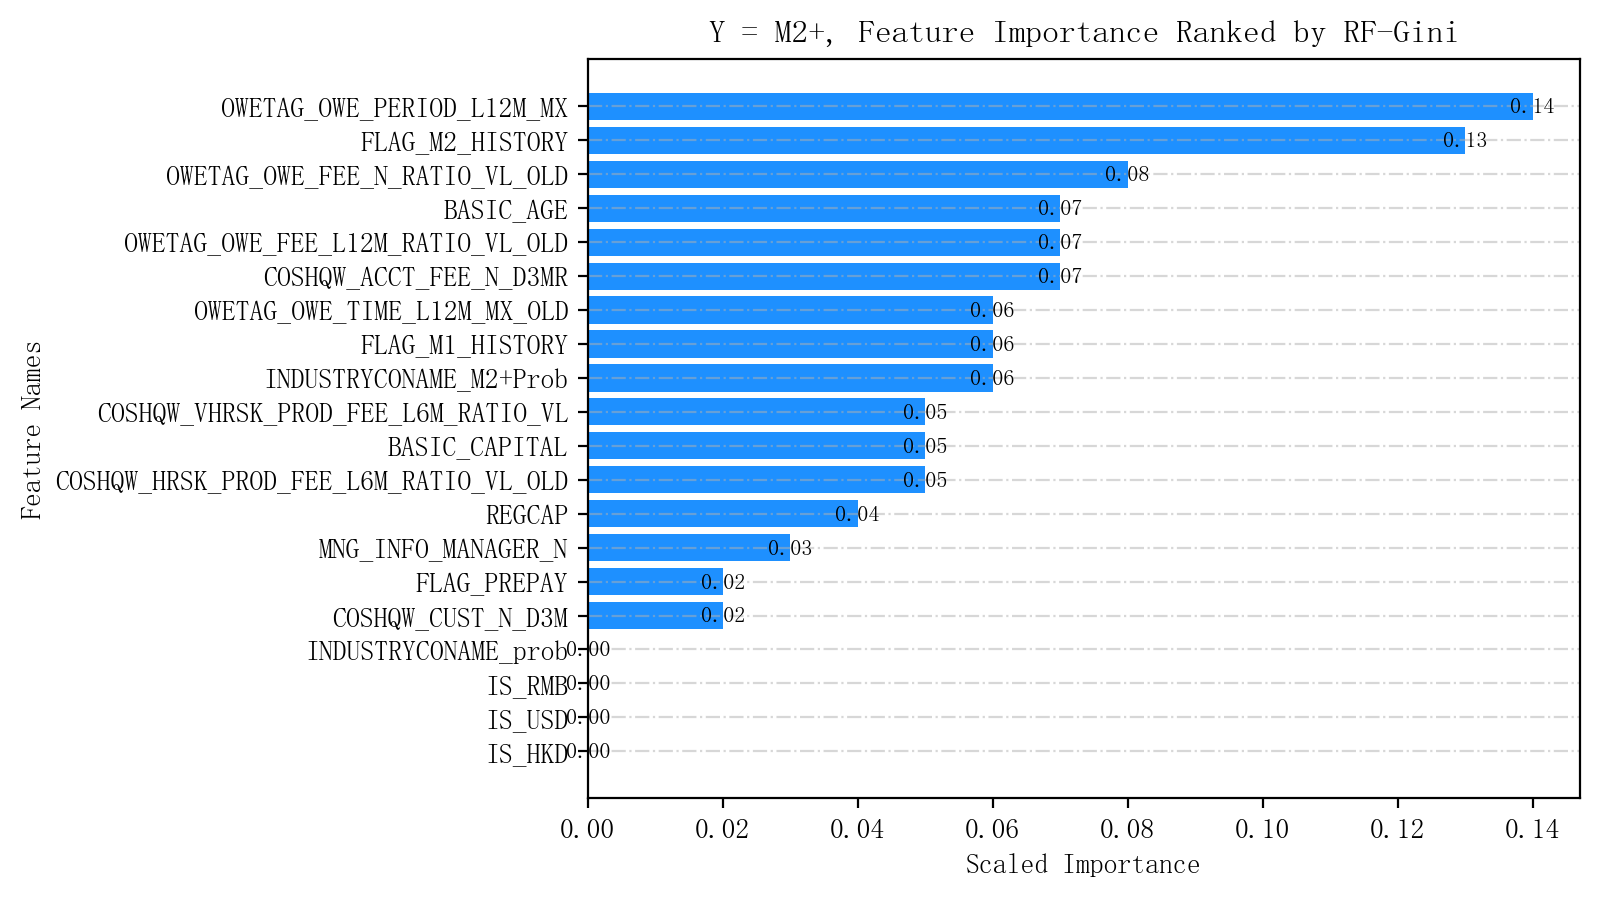

In [155]:
# by RF
df_rf_importance = feature_importance('RF', MODELS[1]['RF'].model.feature_importances_, MODELS[1]['RF'].X_VAL, top_n=20)
plt.title('Y = M2+, Feature Importance Ranked by RF-Gini')

In [125]:
df_rf_importance

,importance,abs_importance
INDUSTRYCONAME_prob,0.000000,0.000000
IS_HKD,0.000647,0.000647
IS_USD,0.002101,0.002101
IS_RMB,0.004369,0.004369
COSHQW_CUST_N_D3M,0.016749,0.016749
FLAG_PREPAY,0.022221,0.022221
MNG_INFO_MANAGER_N,0.032058,0.032058
REGCAP,0.043975,0.043975
COSHQW_VHRSK_PROD_FEE_L6M_RATIO_VL,0.045070,0.045070
BASIC_CAPITAL,0.045098,0.045098


Text(0.5, 1.0, 'Y = M2+, Feature Importance Ranked by Logistic Regression - Weights')

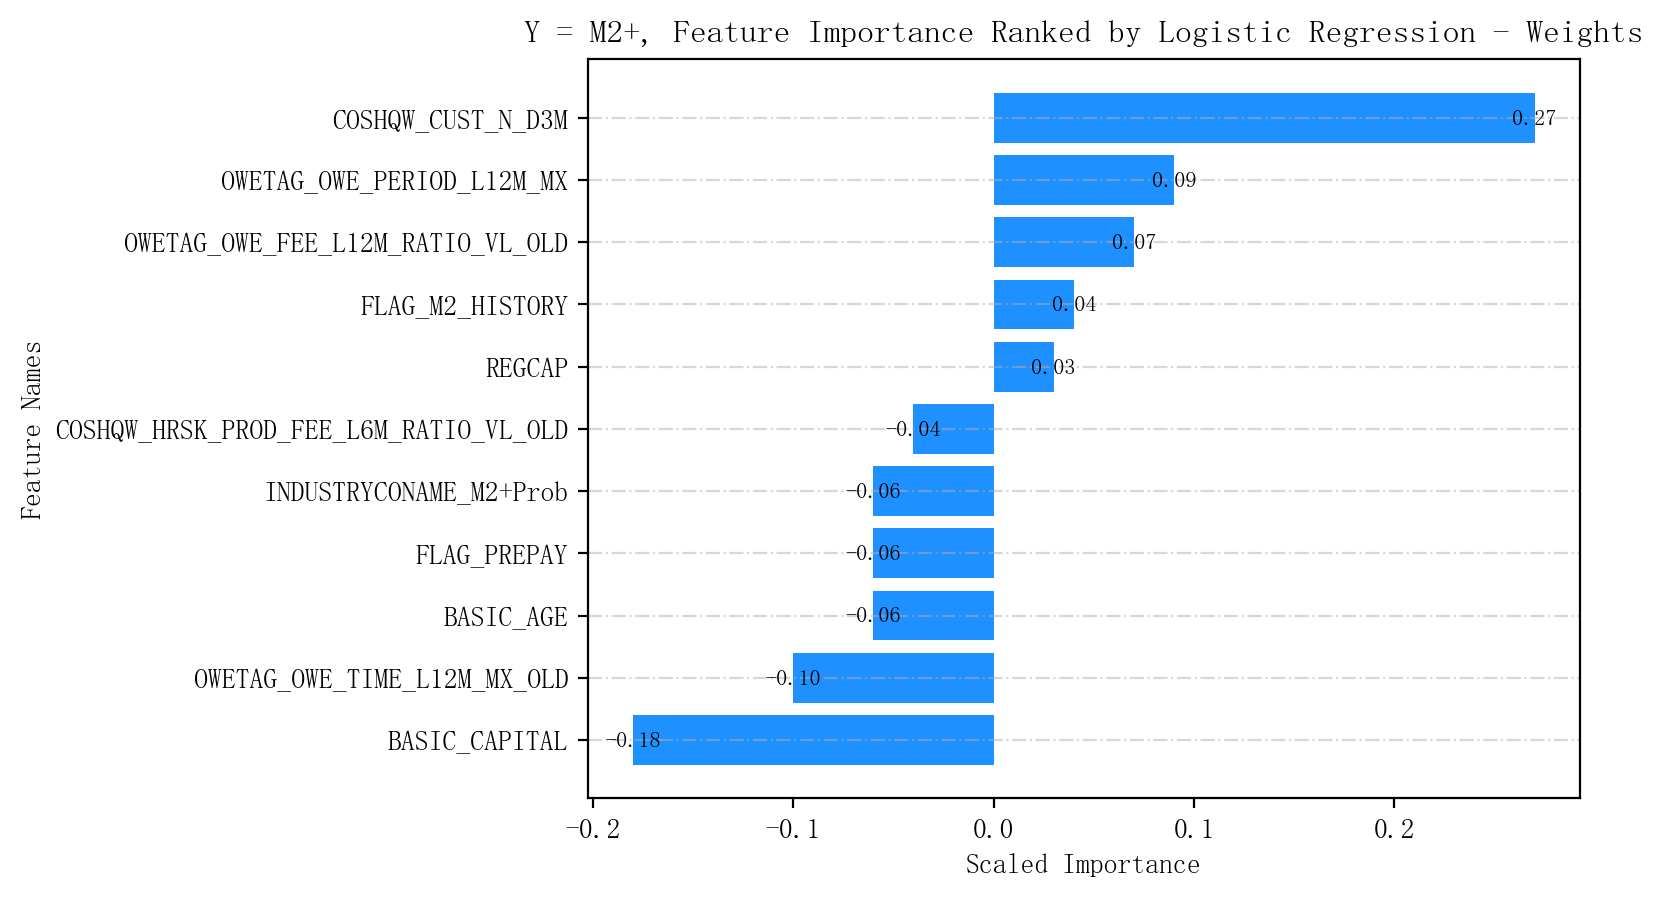

In [156]:
# by LR_WOE
df_lr_importance = feature_importance('LR_WOE', MODELS[1]['LR_WOE'].normalized_importance_glm, MODELS[1]['LR_WOE'].X_test, top_n=30)
plt.title('Y = M2+, Feature Importance Ranked by Logistic Regression - Weights')

In [157]:
df_lr_importance

,importance,abs_importance
BASIC_CAPITAL,-1.557602,-0.18
OWETAG_OWE_TIME_L12M_MX_OLD,-0.913710,-0.10
BASIC_AGE,-0.496275,-0.06
FLAG_PREPAY,-0.548984,-0.06
INDUSTRYCONAME_M2+Prob,-0.512986,-0.06
COSHQW_HRSK_PROD_FEE_L6M_RATIO_VL_OLD,-0.377008,-0.04
REGCAP,0.290581,0.03
FLAG_M2_HISTORY,0.339084,0.04
OWETAG_OWE_FEE_L12M_RATIO_VL_OLD,0.616068,0.07
OWETAG_OWE_PERIOD_L12M_MX,0.802064,0.09


In [162]:
# 随机森林和逻辑回归对变量筛选的综合考虑
threshold = 0.02
print(f'>>> 随机森林和逻辑回归都认为重要的特征 (RF和LR的相对重要性均 > {threshold})：')
RF_XS = df_rf_importance[df_rf_importance['abs_importance'] > threshold].index.tolist()
LR_XS = df_lr_importance[df_lr_importance['abs_importance'].abs() > threshold].index.tolist()
print([i for i in RF_XS if i in LR_XS])
print(f'>>> 随机森林认为重要但逻辑回归认为不重要的特征 (RF相对重要性 > {threshold} 但 LR相对重要性 <= {threshold})：')
print([i for i in RF_XS if i not in LR_XS])
print(f'>>> 逻辑回归认为重要但随机森林认为不重要的特征 (LR相对重要性 > {threshold} 但 RF相对重要性 <= {threshold})：')
print([i for i in LR_XS if i not in RF_XS])

>>> 随机森林和逻辑回归都认为重要的特征 (RF和LR的相对重要性均 > 0.02)：
['REGCAP', 'COSHQW_HRSK_PROD_FEE_L6M_RATIO_VL_OLD', 'BASIC_CAPITAL', 'INDUSTRYCONAME_M2+Prob', 'OWETAG_OWE_TIME_L12M_MX_OLD', 'OWETAG_OWE_FEE_L12M_RATIO_VL_OLD', 'BASIC_AGE', 'FLAG_M2_HISTORY', 'OWETAG_OWE_PERIOD_L12M_MX']
>>> 随机森林认为重要但逻辑回归认为不重要的特征 (RF相对重要性 > 0.02 但 LR相对重要性 <= 0.02)：
['MNG_INFO_MANAGER_N', 'COSHQW_VHRSK_PROD_FEE_L6M_RATIO_VL', 'FLAG_M1_HISTORY', 'COSHQW_ACCT_FEE_N_D3MR', 'OWETAG_OWE_FEE_N_RATIO_VL_OLD']
>>> 逻辑回归认为重要但随机森林认为不重要的特征 (LR相对重要性 > 0.02 但 RF相对重要性 <= 0.02)：
['FLAG_PREPAY', 'COSHQW_CUST_N_D3M']


Text(0.5, 1.0, 'Y = M2+, Feature Importance Ranked by LightGBDT-Split')

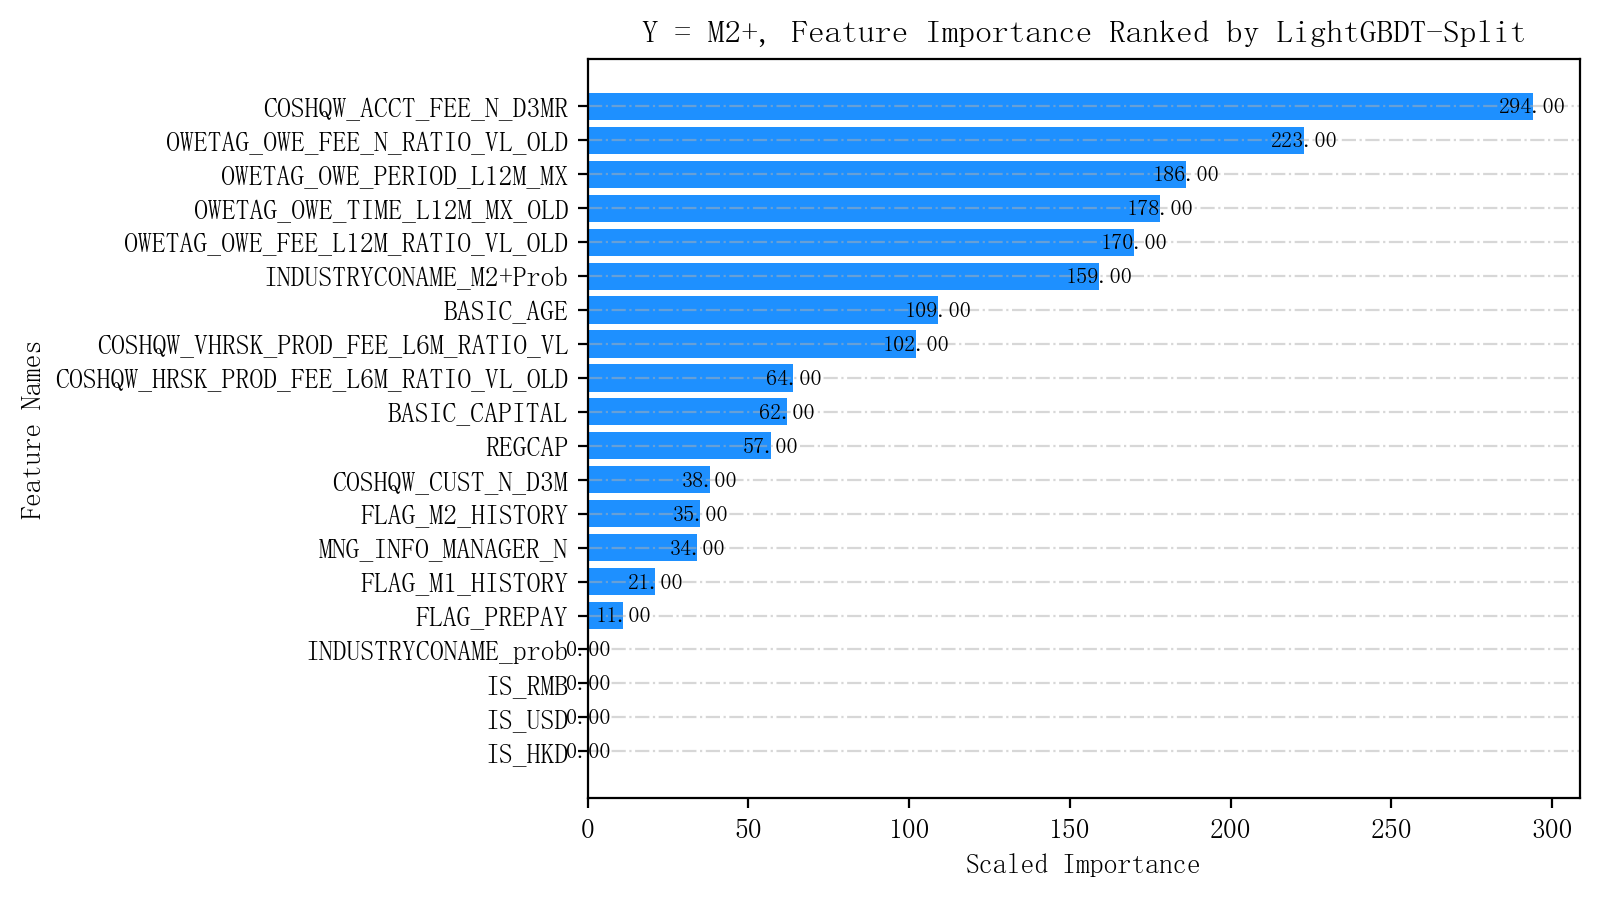

In [99]:
# by LGB
MODELS[4]['LightGBDT'].plot_feature_importance(top_n=20, importance_type='split')
plt.title('Y = M2+, Feature Importance Ranked by LightGBDT-Split')

In [ ]:
test_eva_df.to_csv('OweRate_ModelSelection_10-fold_TestSet.csv', index=False)
test_eva_gb.to_csv('OweRate_ModelSelection_nested_TestSet.csv', index=True)

### Owe_Rate: LGB v.s. LR v.s. RF

In [106]:
# Data Parameters
PK = 'NATURAL_CUST_ID'
TARGET_2 = 'target_oweRate_binary'
DROP_2 = [PK] + ['target_owe_fee_rate','target_M2plus','INDUSTRYCONAME', 'INDUSTRYCONAME_M2+Prob', 'INDUSTRYCONAME_prob']
FEATURES_2 = df.drop(columns=DROP_2).columns.tolist()

# WOE Feature Screening and Transformation
EMP = 0.9; IV = 0.02; COR = 0.7
X2DROP = True
BIN_METHOD = 'chi'; BIN_MIN = 0.05
WOE_METHOD = 'aic'; WOE_REG = 'ridge'

# Model Selections
MODEL_NAMES = ['LR', 'LightGBDT', 'RF','LR_WOE', 'LightGBDT_WOE', 'RF_WOE']

#### Training

In [107]:
MODELS_2, TEST_INDICATORS_2, TRAIN_INDICATORS_2 = model_selection('binary', KF_DATASETS, TARGET_2, DROP_2, FEATURES_2, 
                                                    EMP, IV, COR, X2DROP, BIN_METHOD, BIN_MIN, WOE_METHOD, WOE_REG,
                                                    MODEL_NAMES,
                                                    COMPARE_PARAM = True, n_estimators_uplimit = 300, K = 3)

>> Dataset 9, Model Processing: 100%|██████████| 6/6 [07:41<00:00, 76.83s/it]


#### Evaluation

In [108]:
indicators = ['train_KS','train_AUC','train_precision','train_recall','train_F1']

train_eva_df_2 = pd.DataFrame(data=TRAIN_INDICATORS_2,
                            columns=['model','fold','train_KS','train_AUC','train_precision','train_recall','train_F1'])

train_eva_df_2.sort_values(['train_KS','train_AUC'],ascending=False)

,model,fold,train_KS,train_AUC,train_precision,train_recall,train_F1
2,RF,1,1.000000,1.000000,1.000000,1.000000,1.000000
8,RF,2,1.000000,1.000000,1.000000,1.000000,1.000000
14,RF,3,1.000000,1.000000,1.000000,1.000000,1.000000
20,RF,4,1.000000,1.000000,1.000000,1.000000,1.000000
26,RF,5,1.000000,1.000000,1.000000,1.000000,1.000000
32,RF,6,1.000000,1.000000,1.000000,1.000000,1.000000
38,RF,7,1.000000,1.000000,1.000000,1.000000,1.000000
44,RF,8,1.000000,1.000000,1.000000,1.000000,1.000000
50,RF,9,1.000000,1.000000,1.000000,1.000000,1.000000
11,RF_WOE,2,0.966210,0.983105,0.990299,0.968030,0.979038


In [109]:
print(f'>>> {K}-fold Cross Validation Results in Train set:')
train_eva_df_2.groupby('model')[indicators].agg(['mean','median','max','min','std'])

>>> 10-fold Cross Validation Results in Train set:


train_KS                                         train_AUC  \
                   mean    median       max       min       std      mean   
model                                                                       
LR             0.002246  0.002210  0.003218  0.001147  0.000543  0.501123   
LR_WOE         0.661012  0.664742  0.671922  0.642629  0.010398  0.830506   
LightGBDT      0.392621  0.657870  0.744235  0.000000  0.373139  0.696310   
LightGBDT_WOE  0.372734  0.425029  0.708453  0.000000  0.318822  0.686367   
RF             1.000000  1.000000  1.000000  1.000000  0.000000  1.000000   
RF_WOE         0.921910  0.920747  0.966210  0.863304  0.031892  0.960955   

                                                       ... train_recall  \
                 median       max       min       std  ...         mean   
model                                                  ...                
LR             0.501105  0.501609  0.500573  0.000272  ...     0.002478   
LR_WOE         0.832371  0.835961  0.821315  0.005199  ...     0.691591   
LightGBDT      0.828935  0.872117  0.500000  0.186570  ...     0.406960   
LightGBDT_WOE  0.712514  0.854226  0.500000  0.159411  ...     0.386338   
RF             1.000000  1.000000  1.000000  0.000000  ...     1.000000   
RF_WOE         0.960373  0.983105  0.931652  0.015946  ...     0.926951   

                                                       train_F1            \
                 median       max       min       std      mean    median   
model                                                                       
LR             0.002434  0.003479  0.001355  0.000559  0.004936  0.004850   
LR_WOE         0.695292  0.704271  0.672781  0.011255  0.747855  0.750109   
LightGBDT      0.679199  0.773717  0.000000  0.386848  0.436105  0.758840   
LightGBDT_WOE  0.432674  0.738898  0.000000  0.332242  0.444614  0.587672   
RF             1.000000  1.000000  1.000000  0.000000  1.000000  1.000000   
RF_WOE         0.926633  0.968030  0.871020  0.029629  0.949102  0.946993   

                                             
                    max       min       std  
model                                        
LR             0.006924  0.002703  0.001110  
LR_WOE         0.754636  0.734861  0.006160  
LightGBDT      0.803517  0.000000  0.413887  
LightGBDT_WOE  0.779785  0.000000  0.357414  
RF             1.000000  1.000000  0.000000  
RF_WOE         0.979038  0.911765  0.021885  

[6 rows x 25 columns]

In [110]:
indicators = ['test_KS','test_AUC','test_precision','test_recall','test_F1']

test_eva_df_2 = pd.DataFrame(data=TEST_INDICATORS_2,
                      columns=['model','fold','test_KS','test_AUC','test_precision','test_recall','test_F1'])

test_eva_df_2.sort_values(['test_KS','test_AUC'],ascending=False)

,model,fold,test_KS,test_AUC,test_precision,test_recall,test_F1
25,LightGBDT,5,0.744703,0.872351,0.821244,0.776961,0.798489
49,LightGBDT,9,0.719662,0.859831,0.820728,0.749361,0.783422
31,LightGBDT,6,0.714616,0.857308,0.794521,0.749354,0.771277
52,LightGBDT_WOE,9,0.710835,0.855417,0.801653,0.744246,0.771883
32,RF,6,0.708448,0.854224,0.812500,0.739018,0.774019
28,LightGBDT_WOE,5,0.697086,0.848543,0.818182,0.727941,0.770428
37,LightGBDT,7,0.694445,0.847223,0.846377,0.719212,0.777630
34,LightGBDT_WOE,6,0.688118,0.844059,0.774105,0.726098,0.749333
21,LR_WOE,4,0.684220,0.842110,0.857143,0.708333,0.775665
53,RF_WOE,9,0.684094,0.842047,0.802292,0.716113,0.756757


In [111]:
print(f'>>> {K}-fold Cross Validation Results in Test set:')
test_eva_gb_2 = test_eva_df_2.groupby('model')[indicators].agg(['mean','max','min','std'])
test_eva_gb_2

>>> 10-fold Cross Validation Results in Test set:


test_KS                                test_AUC            \
                   mean       max       min       std      mean       max   
model                                                                       
LR             0.001810  0.004739  0.000000  0.001856  0.500879  0.502370   
LR_WOE         0.653516  0.684220  0.593559  0.034599  0.826758  0.842110   
LightGBDT      0.391961  0.744703  0.000000  0.372615  0.695981  0.872351   
LightGBDT_WOE  0.369748  0.710835  0.000000  0.322781  0.684874  0.855417   
RF             0.668368  0.708448  0.629575  0.021046  0.834184  0.854224   
RF_WOE         0.641897  0.684094  0.562820  0.040156  0.820948  0.842047   

                                  test_precision                      \
                    min       std           mean       max       min   
model                                                                  
LR             0.499766  0.000959       0.466667  1.000000  0.000000   
LR_WOE         0.796779  0.017299       0.811729  0.857143  0.778090   
LightGBDT      0.500000  0.186307       0.462153  0.876506  0.000000   
LightGBDT_WOE  0.500000  0.161391       0.566390  0.920398  0.000000   
RF             0.814787  0.010523       0.838622  0.869822  0.812500   
RF_WOE         0.781410  0.020078       0.772755  0.802292  0.727763   

                        test_recall                                 test_F1  \
                    std        mean       max       min       std      mean   
model                                                                         
LR             0.444410    0.002121  0.004739  0.000000  0.001830  0.004218   
LR_WOE         0.025447    0.683808  0.715762  0.620853  0.034627  0.741832   
LightGBDT      0.438983    0.407611  0.776961  0.000000  0.387692  0.432511   
LightGBDT_WOE  0.427367    0.384255  0.744246  0.000000  0.337320  0.437497   
RF             0.015597    0.693940  0.739018  0.656398  0.022371  0.759130   
RF_WOE         0.023691    0.680214  0.716113  0.599526  0.040963  0.722935   

                                             
                    max       min       std  
model                                        
LR             0.009434  0.000000  0.003641  
LR_WOE         0.775665  0.699438  0.025438  
LightGBDT      0.798489  0.000000  0.410431  
LightGBDT_WOE  0.771883  0.000000  0.357381  
RF             0.774019  0.732804  0.011676  
RF_WOE         0.756757  0.671979  0.028237

#### Feature Importance

Text(0.5, 1.0, 'Y = OweRate_binary, Feature Importance Ranked by RF-Gini')

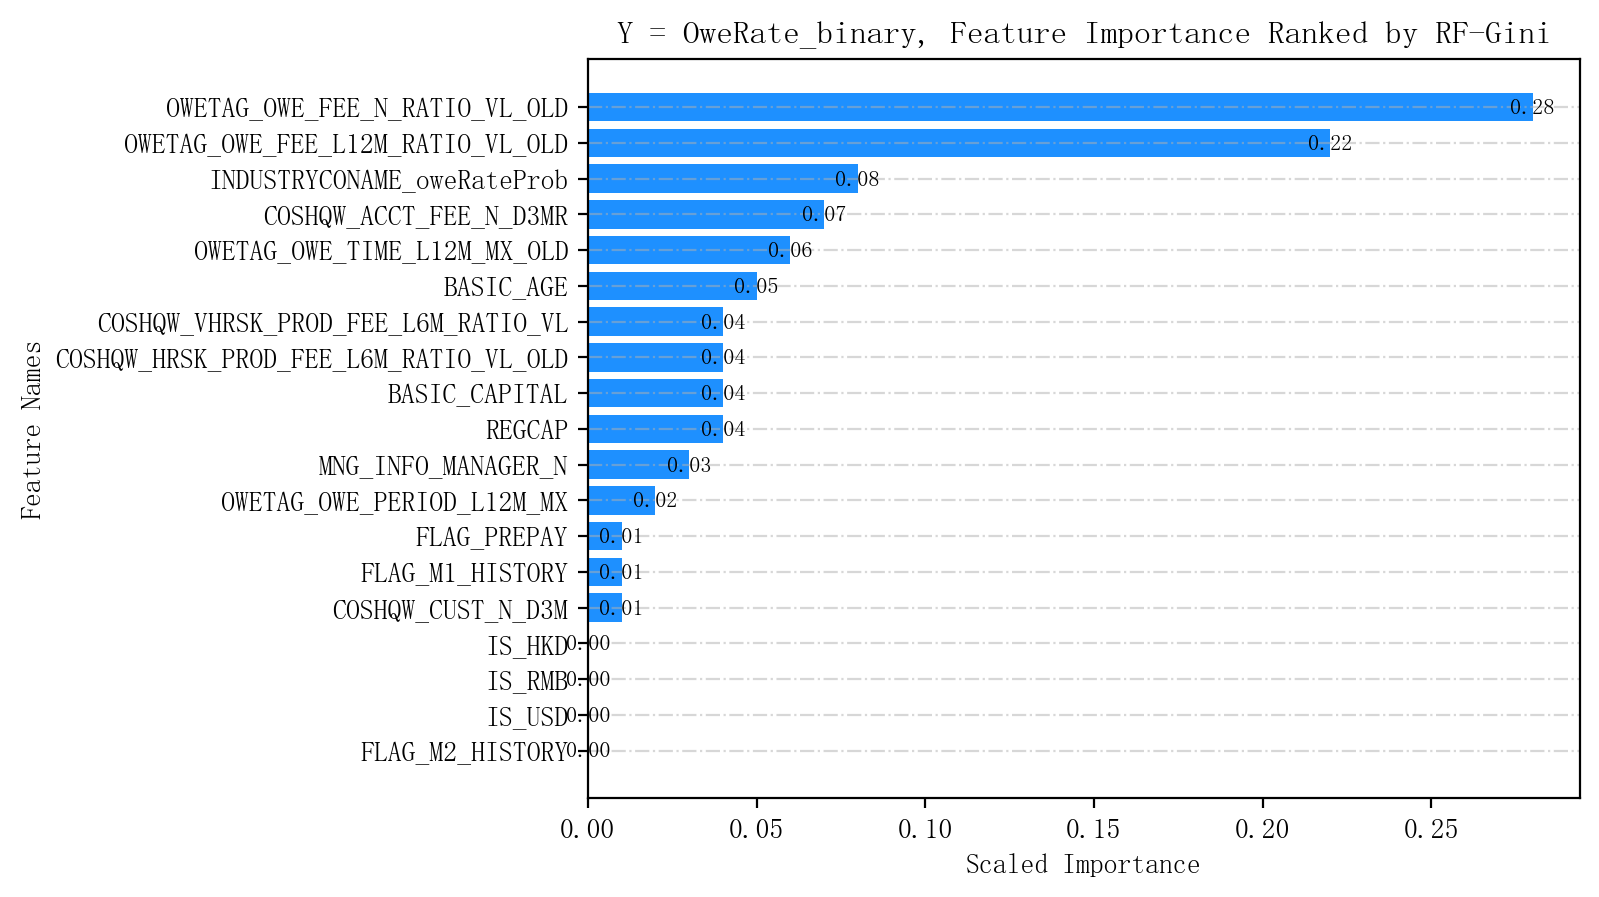

In [169]:
# by RF
df_rf_importance_2 = feature_importance('RF', MODELS_2[6]['RF'].model.feature_importances_, MODELS_2[6]['RF'].X_VAL, top_n=20)
plt.title('Y = OweRate_binary, Feature Importance Ranked by RF-Gini')

Text(0.5, 1.0, 'Y = OweRate_binary, Feature Importance Ranked by LR_WOE-Gini')

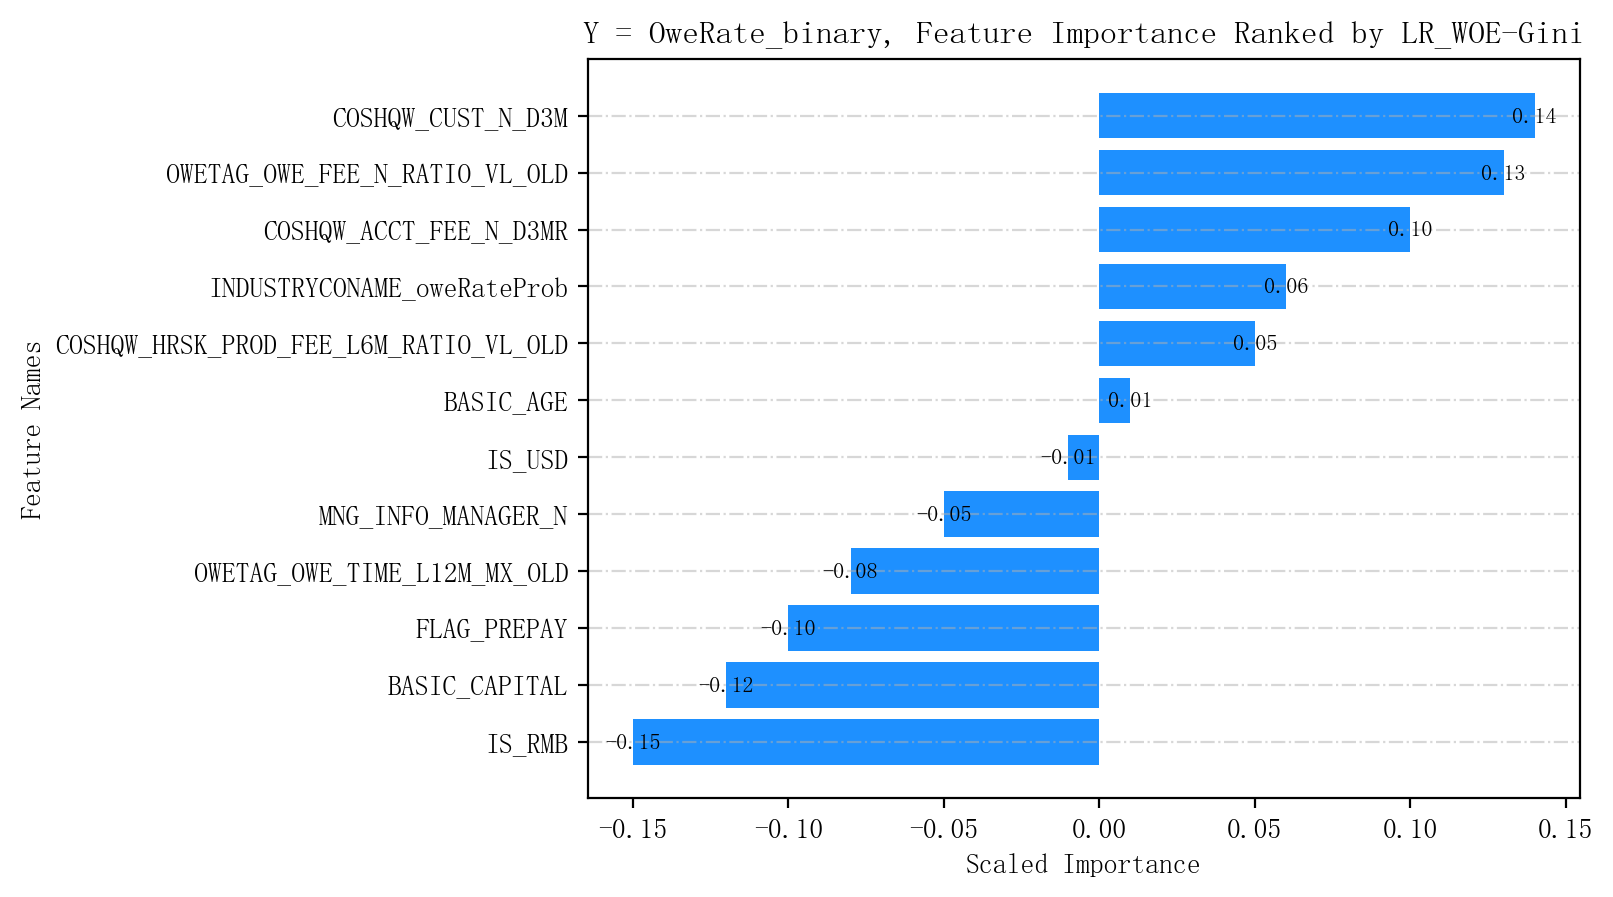

In [170]:
# by LR_WOE
df_lr_importance_2 = feature_importance('LR_WOE', MODELS_2[6]['LR_WOE'].normalized_importance_glm, MODELS_2[6]['LR_WOE'].X_test, top_n=20)
plt.title('Y = OweRate_binary, Feature Importance Ranked by LR_WOE-Gini')

In [171]:
# 随机森林和逻辑回归对变量筛选的综合考虑
threshold = 0.02
print(f'>>> 随机森林和逻辑回归都认为重要的特征 (RF和LR的相对重要性均 > {threshold})：')
RF_XS = df_rf_importance_2[df_rf_importance_2['abs_importance'] > threshold].index.tolist()
LR_XS = df_lr_importance_2[df_lr_importance_2['abs_importance'].abs() > threshold].index.tolist()
print([i for i in RF_XS if i in LR_XS])
print(f'>>> 随机森林认为重要但逻辑回归认为不重要的特征 (RF相对重要性 > {threshold} 但 LR相对重要性 <= {threshold})：')
print([i for i in RF_XS if i not in LR_XS])
print(f'>>> 逻辑回归认为重要但随机森林认为不重要的特征 (LR相对重要性 > {threshold} 但 RF相对重要性 <= {threshold})：')
print([i for i in LR_XS if i not in RF_XS])

>>> 随机森林和逻辑回归都认为重要的特征 (RF和LR的相对重要性均 > 0.02)：
['MNG_INFO_MANAGER_N', 'BASIC_CAPITAL', 'COSHQW_HRSK_PROD_FEE_L6M_RATIO_VL_OLD', 'OWETAG_OWE_TIME_L12M_MX_OLD', 'COSHQW_ACCT_FEE_N_D3MR', 'INDUSTRYCONAME_oweRateProb', 'OWETAG_OWE_FEE_N_RATIO_VL_OLD']
>>> 随机森林认为重要但逻辑回归认为不重要的特征 (RF相对重要性 > 0.02 但 LR相对重要性 <= 0.02)：
['REGCAP', 'COSHQW_VHRSK_PROD_FEE_L6M_RATIO_VL', 'BASIC_AGE', 'OWETAG_OWE_FEE_L12M_RATIO_VL_OLD']
>>> 逻辑回归认为重要但随机森林认为不重要的特征 (LR相对重要性 > 0.02 但 RF相对重要性 <= 0.02)：
['IS_RMB', 'FLAG_PREPAY', 'COSHQW_CUST_N_D3M']


In [114]:
test_eva_df_2.to_csv('OweRate_ModelSelection_10-fold_TestSet.csv', index=False)
test_eva_gb_2.to_csv('OweRate_ModelSelection_nested_TestSet.csv', index=True)